In [6]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading the HShen, there are some weird things with the temperature ranges of this one

In [44]:
import h5py

test = 'HShen_HyperonEOS_rho220_temp180_ye65_version_1.1_20131007.h5'
ftest = h5py.File(test)
print(list(ftest.keys()))

print('log', get_bounds(ftest['logrho'][:]),   'g/cm^3')
print('log', get_bounds(ftest['logpress'][:]), 'MeV/fm^3')
print('log', get_bounds(ftest['ye'][:]))
ftest.close()

['Abar', 'Meff', 'Xa', 'Xh', 'Xn', 'Xp', 'Zbar', 'cs2', 'dedt', 'dpderho', 'dpdrhoe', 'energy_shift', 'entropy', 'gamma', 'logenergy', 'logpress', 'logrho', 'logtemp', 'mu_e', 'mu_n', 'mu_p', 'muhat', 'munu', 'pointsrho', 'pointstemp', 'pointsye', 'timestamp', 'ye']
log [3.0, 16.0] g/cm^3
log [18.573418605725163, 37.161923489191174] MeV/fm^3
log [0.01, 0.65]


In [8]:
def get_bounds(x):
    return [np.min(x), np.max(x)]

In [10]:
filename = 'Hempel_SFHoEOS_rho222_temp180_ye60_version_1.1_20120817.h5'

# Figuring out the units

### Testing speed of different integrators

In [18]:
import time
# rhoc = 3e15 * 1.6199e-18
for integrator in ["dop853","dopri5","vode","lsoda"]:
    start1 = time.time()
    print('initiating')
    test = TableStar(filename).set_initial_conditions(rhoc = 10**-3)
    start = time.time()
    print('solving with %s' % 10**-3, (start - start1))
    solver, r_values, values = test.solve_star_ode(Nr = 100, integrator = integrator)
    stop = time.time()
    print('time use: ', stop - start)

    plt.plot(r_values)#, solver.y[1])

initiating
solving with 0.001 0.8251006603240967


KeyboardInterrupt: 

# compare solver stability

In [67]:
test = TableStar(filename).set_initial_conditions(rhoc = 10**-3.2)

Nr_values = np.linspace(100, 200, 5, dtype = np.int64)
t_v = {}
y_v = {}
integrator = 'dopri5'
for integrator in ["dop853","dopri5","vode","lsoda"]:
    print(integrator)
    t_v[integrator] = []
    y_v[integrator] = []

    for Nr in Nr_values:
        print(Nr)
        solver, t1, y1 = test.solve_star_ode(Nr = Nr, integrator = integrator)
        t_v[integrator].append(t1[-1])
        y_v[integrator].append(y1[-1])

dop853
100


/home/halvard/anaconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dop853: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))


125
150
175
200
dopri5
100
125
150
175
200
vode
100


/home/halvard/anaconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1009: UserWarning: vode: Repeated convergence failures. (Perhaps bad Jacobian supplied or wrong choice of MF or tolerances.)
  self.messages.get(istate, unexpected_istate_msg)))


125
150
175
200
lsoda
100
125
150
175
200


In [19]:
to_km = 1e-5/6.7706e-6

for integrator in ["dop853","dopri5","vode","lsoda"]:
    plt.plot(Nr_values, np.array(t_v[integrator]) * to_km, label = integrator)
plt.xlabel('Nr')
plt.ylabel('Radius [km]')
plt.legend()

NameError: name 'Nr_values' is not defined

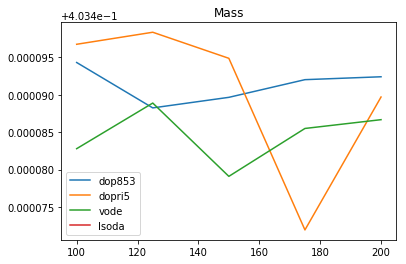

In [89]:
for integrator in ["dop853","dopri5","vode","lsoda"]:

    plt.plot(Nr_values, np.array(y_v[integrator])[:,0], label = integrator)
plt.title('Mass')
plt.legend()

# Test dopri5 for low values of Nr

10


/home/halvard/anaconda3/lib/python3.6/site-packages/scipy/integrate/_ode.py:1177: UserWarning: dopri5: step size becomes too small
  self.messages.get(istate, unexpected_istate_msg)))
/home/halvard/uio/PHY905_NumericalRelativity/project1/tov.py:158: UserWarning: Something went wrong in the integration, and we need a better error message
  warnings.warn('Something went wrong in the integration, and we need a better error message')


23
56
133
316


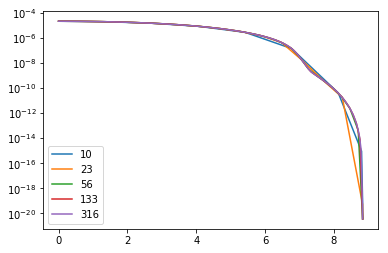

In [20]:
test = TableStar(filename).set_initial_conditions(rhoc = 10**-3.2)

Nr_values = np.logspace(1, 2.5, 5, dtype = np.int64)
t_dp5 = []
y_dp5 = []
integrator = 'dopri5'

for Nr in Nr_values:
    print(Nr)
    solver, t1, y1 = test.solve_star_ode(Nr = Nr, integrator = integrator)
    t_dp5.append(t1[-1])
    y_dp5.append(y1[-1])
    # rho = [test.rho(P) for P in y1[:,1]]
    # plt.semilogy(t1, rho)
    plt.semilogy(t1, y1[:,1], label = "{:.0f}".format(Nr))
plt.legend()

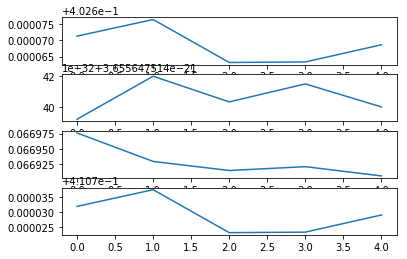

In [21]:
y_dp5 = np.array(y_dp5)
i = 0
np.std(y_dp5, axis=0)
fig, axes = plt.subplots(4)
for i in range(4):
    axes[i].plot(y_dp5[:,i])

### Seems like even a value of N = 10 works... 
Lets test this more thoroughly. First make a good standard of high values with $N$ in the 100-range, finding mass and radius averages and deviations

In [194]:
test = TableStar(filename).set_initial_conditions(rhoc = 10**-3.2)
integrator = 'dopri5'

good_y = []
good_t = []
for Nr in range(90,121,5):
    print(Nr)
    solver, t, y = test.solve_star_ode(Nr = Nr, integrator = integrator)
    
    good_t.append(t[-1])
    good_y.append(y[-1])
    
mean_r = np.mean(good_t)
mean_m = np.mean(np.array(good_y)[:,0])
mean_m

90
95
100
105
110
115
120


0.403498614904069

check at which N the deviation from the good value is more than a percent

In [208]:
for Nr in np.logspace(2, 0, 8, dtype=int):
    print(Nr)
    solver, t, y = test.solve_star_ode(Nr = Nr, integrator = integrator)
    print(len(t))
    
    diff = np.abs(y[-1, 0] - mean_m)/mean_m 
    print(diff, diff > 0.01)

100
28
4.665339383436971e-06 False
51
15
7.902255797879383e-07 False
26
10
1.1165105166174493e-05 False
13
5
3.1796032173160266e-05 False
7
3
2.466774839226729e-05 False
3
4
1.4931225590367916e-05 False
1
3
2.2211038641860895e-05 False
1
3
2.2211038641860895e-05 False


In [212]:
solver, t, y = test.solve_star_ode(Nr = 50, integrator = integrator)

3.3853e-07
0.67706033853
1.35412033853
2.03118033853
2.70824033853
3.38530033853
4.0623603385300004
4.73942033853
5.41648033853
6.09354033853
6.77060033853
7.44766033853
8.12472033853
8.801780338530001


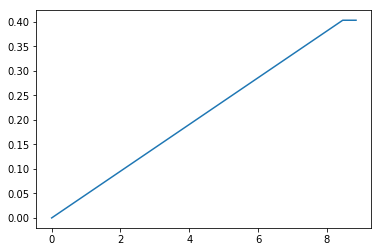

In [205]:
plt.plot(t, y[:,0])

In [201]:
diff

2.2211038641860895e-05

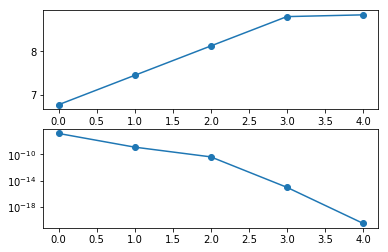

In [131]:

_, [ax1,ax2] = plt.subplots(2)
ax1.plot(t1[-5:], 'o-')
ax2.semilogy(y1[-5:,1], 'o-')

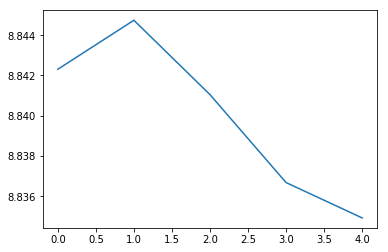

In [118]:
plt.plot(t_dp5)

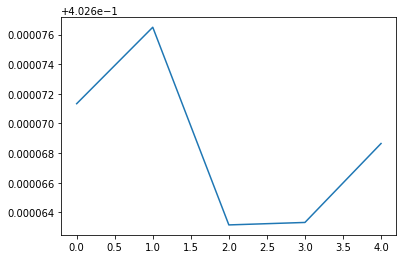

In [52]:
plt.plot(np.array(y_dp5)[:,0])

initiating
solving with 0.00501 0.7934191226959229
solving with 0.00490 0.7934191226959229
time use:  12.10019588470459


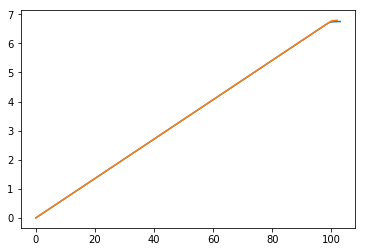

In [57]:
import time
Nr = 200
# r_max = 

start1 = time.time()
print('initiating')
rhoc = 10**-2.30
test = TableStar(filename).set_initial_conditions(rhoc = rhoc)
start = time.time()
print('solving with %.5f'%rhoc, start - start1)
solver, t1, y1 = test.solve_star_ode(Nr = 200, integrator = 'vode')

rhoc = 10**-2.31
print('solving with %.5f'%rhoc, start - start1)
test.set_initial_conditions(rhoc = rhoc)
solver, t2, y2 = test.solve_star_ode(Nr = 200, integrator = 'vode')
stop = time.time()
print('time use: ', stop - start)

plt.plot(t1)#, solver.y[1])
plt.plot(t2)#, solver.y[1])

### Edges looks like this

[35, 45, 6, 7.5]

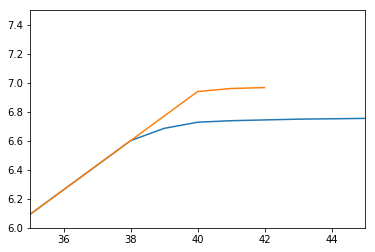

In [23]:
plt.plot(t1)#, solver.y[1])
plt.plot(t2)#, solver.y[1])
plt.axis([35,45,6,7.5])

In [22]:
# plt.semilogy(t1, y1[:, 1], label = 'pressure, $\rho_c = 10^-{2.3}$')
# plt.semilogy(t2, y2[:, 1], label = 'pressure, $\rho_c = 10^-{2.35}$')
# plt.axhline(10**test.pres_bounds[0], 'pressure lower bound')
# plt.legend()

(-15.570458338804938, -2.2904585388049377)
-3.4
-3.3
-3.1999999999999997
-3.0999999999999996
-3.0
-2.9


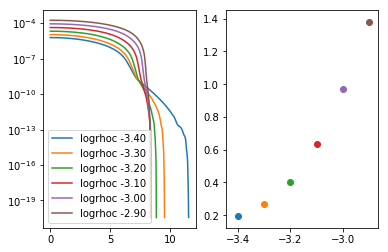

In [85]:
fig,[ax1,ax2] = plt.subplots(1,2)

final_values = []
integrator = 'vode'
Nr = 200


star = TableStar(filename)

print(test.rho_bounds)
#for logrhoc in np.linspace(-3.3, -2.2903, 30):
for logrhoc in np.linspace(-3.4, -2.9, 6):
    
    print(logrhoc)
    star.set_initial_conditions(rhoc = 10**logrhoc)
    solver, t, y = star.solve_star_ode(integrator = integrator, Nr = Nr)
    
    last_pos = -1 # Edge finding ensures last position at pressure < tol
    final_values.append([logrhoc, t[last_pos]] + list(y[last_pos]))
    
    ax1.semilogy(t, y[:, 1], label = 'logrhoc {:.2f}'.format(logrhoc))
    ax2.scatter(logrhoc, y[last_pos, 0])
ax1.legend()
# rhoc = 3e15 * 1.6199e-18
# test = TableStar(filename).set_initial_conditions(rhoc = rhoc)

In [ ]:
y2 = 

(-20.73203909100906, -2.068360655411844) (0.01, 0.6)


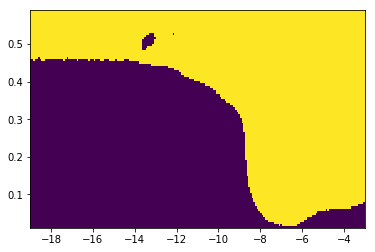

In [309]:
star.rho_interp
print(star.pres_bounds, star.ye_bounds)

x = np.linspace(-19, -3, 200)
y = np.linspace(0.011, 0.59, 100)
x,y = np.meshgrid(x,y)
z = star.munu_interp_pres(y,x)
plt.pcolormesh(x,y,z>0)

(-15.570458338804938, -2.2904585388049377)


Text(0,0.5,'ye')

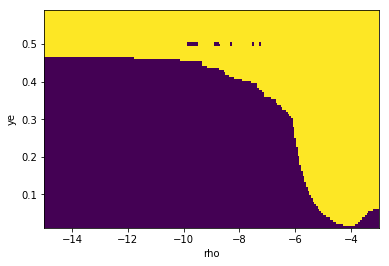

In [311]:
print(star.rho_bounds)

x2 = np.linspace(-15, -3, 200)
x2,y2 = np.meshgrid(x2,y)
z2 = star.munu_interp_rho(y2,x2)
plt.pcolormesh(x2,y2,z2>0)
plt.xlabel('rho')
plt.ylabel('ye')

In [280]:
import numpy as np
import h5py
from tov import TableStar, BaseStar
from scipy.interpolate import UnivariateSpline

class TestTable(TableStar):

    """Docstring for TestTable. """

    def __init__(self, tablefile, scaling = {}, *args, **kwargs):
        """Assumes cold star, i.e minimal T. 
        
        Scales to geometrized units c = G = M_sun = 1
        """
        BaseStar.__init__(self, *args, **kwargs)
        self._allow_negative_pressure = True

        f = h5py.File(tablefile, 'r')
        
        self.scaling = {}
        
        # default scaling is  c = G = M_sun = 1
        default_scaling = {'pres'  : 1.801569643420104e-39, # from dyn/cm^2
                           'rho'   : 1.6191700468788605e-18, # from g/cm^3
                           'specific_energy': 1.11265005605e-21,  # from erg/g
                           # munu should be MeV/baryon
                          }
        default_scaling.update(scaling)
        self.scaling.update(default_scaling)
        
        self.ye_arr   = f['ye'][:] 
        self.rho_arr  = f['logrho'][:] + np.log10(self.scaling['rho'])
        
        self.energy_shift  = f['energy_shift'][0] * self.scaling['specific_energy']

        rho_grid, ye_grid  = np.meshgrid(self.rho_arr, self.ye_arr)
        pres_values   = f['logpress'][:,0,:]  + np.log10(self.scaling['pres'])
        munu_values   = f['munu'][:,0,:]      # *          self.scaling['energy']
        energy_values = f['logenergy'][:,0,:] + np.log10(self.scaling['specific_energy']) 
        f.close()

        self.ye_bounds   = (np.min(self.ye_arr),  np.max(self.ye_arr))
        self.rho_bounds  = (np.min(self.rho_arr), np.max(self.rho_arr))
        self.pres_bounds = (np.min(pres_values),  np.max(pres_values))

        self.energy_arr = np.zeros_like(self.rho_arr)
        self.pres_arr   = np.zeros_like(self.rho_arr)

        prev_root = 0 
        
        # for each rho, extract the values given ye such that munu = 0
        for i, rho in enumerate(self.rho_arr):
            munu_func   = UnivariateSpline(self.ye_arr, munu_values[:,i],   s=0)
            pres_func   = UnivariateSpline(self.ye_arr, pres_values[:,i],   s=0)
            energy_func = UnivariateSpline(self.ye_arr, energy_values[:,i], s=0)
            
            ye_roots = munu_func.roots()
            
            
            if len(ye_roots) > 1:
                # in case several roots, we pick the closest one
                import warnings
                warnings.warn('Error, more than one root in munu! Using closest to previous')
                i_root = np.argmin(np.abs(np.array(ye_roots) - prev_root))
            else:
                i_root = 0
                
            ye_root = ye_roots[i_root]
            prev_root = ye_root
            
            self.pres_arr[i] = pres_func(ye_root)
            self.energy_arr[i] = energy_func(ye_root)
            
        self.rho_interp    = UnivariateSpline(self.pres_arr, self.rho_arr)
        self.pres_interp   = UnivariateSpline(self.rho_arr, self.pres_arr)
        self.energy_interp = UnivariateSpline(self.rho_arr, self.energy_arr)
#         fig,[ax1,ax2,ax3] = plt.subplots(3)
#         ax1.plot(self.pres_arr, self.rho_arr)
#         ax2.plot(self.rho_arr, self.pres_arr)
#         ax3.plot(self.rho_arr, self.energy_arr)
            
    def energy(self, rho):
        logrho = np.log10(rho)
        return 10**self.energy_interp(logrho) - self.energy_shift
    
    def P(self, rho):
        # a, b = self.ye_bounds
        logrho = np.log10(rho)
        # res = scipy.optimize.bisect(self.munu, a = a, b = b, args=(logrho, 'rho'))
        # self.current_ye = res
        if P < self.
        return 10**self.pres_interp(logrho)
    
    def rho(self, P):
        # a, b = self.ye_bounds
        logP = np.log10(P)
        # res = scipy.optimize.bisect(self.munu, a = a, b = b,  args=(logP, 'pres'))
        # self.current_ye = res
        return 10**self.rho_interp(logP)
    
    def rho0(self, P, rho = None):
        """Uses P as is, no convert to log"""
        rho = rho or self.rho(P)
        eps = self.energy(rho)
        return rho / (1 + eps)


In [304]:
final_values = []
integrator = 'vode'
Nr = 200

from test_table import TestTable
test = TestTable('test/' + filename)

/home/halvard/uio/PHY905_NumericalRelativity/project1/test_table.py:63: UserWarning: Error, more than one root in munu! Using closest to previous
  warnings.warn('Error, more than one root in munu! Using closest to previous')


(-15.570458338804938, -2.2904585388049377)
96


/home/halvard/uio/PHY905_NumericalRelativity/project1/test_table.py:128: RuntimeWarning: invalid value encountered in log10


98
104
112
105
114
123
124
125
123
130
128
133
130
133
132
133
131
144
142


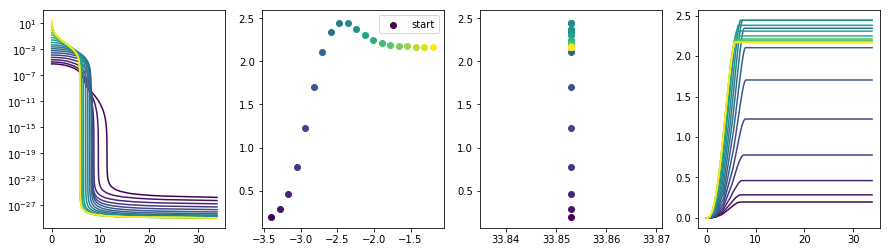

In [306]:
fig,[ax1,ax2,ax3,ax4] = plt.subplots(1,4, figsize = [15,4])

print(test.rho_bounds)
#for logrhoc in np.linspace(-3.3, -2.2903, 30):

a = -3.4
b = -1.2
integrator = 'dopri5'
for logrhoc in np.linspace(a, b, 20):
    # print(logrhoc)
    test.set_initial_conditions(rhoc = 10**logrhoc)
    # solver, t, y = test.solve_star_ode(integrator = integrator, Nr = Nr)
    solver= test.solve_star_ivp(integrator = integrator)# , Nr = Nr)
    t = solver.t
    y = solver.y.T
    
    last_pos = -1 # Edge finding ensures last position at pressure < tol
    final_values.append([logrhoc, t[last_pos]] + list(y[last_pos]))
    
    c = plt.cm.viridis((logrhoc-a) / (b - a))
    print(len(t))
    ax1.semilogy(t, y[:, 1], label = 'logrhoc {:.2f}'.format(logrhoc), color = c)
    ax2.scatter(logrhoc, y[last_pos, 0], c = c)
    ax3.scatter(t[last_pos], y[last_pos, 0], c = c)
    ax4.plot(t, y[:, 0], c = c)
    
ax2.legend(['start'])
# rhoc = 3e15 * 1.6199e-18
# test = TableStar(filename).set_initial_conditions(rhoc = rhoc)

In [271]:
rho, r_values, m_values, P_values, phi_values, M0_values = np.array(final_values).T
print(star.r_max/100)

0.135412


In [272]:
7.5*to_km

11.077304817889111

Text(0,0.5,'Mass [$M_\\odot$]')

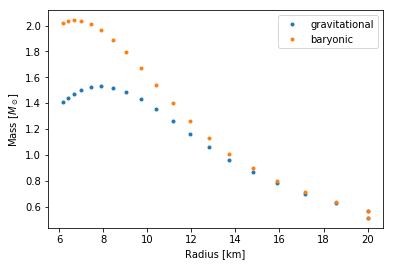

In [273]:
to_km = 1e-5/6.7706e-6

plt.plot(to_km*r_values, m_values, '.', label = 'gravitational')
plt.plot(to_km*r_values, M0_values, '.', label = 'baryonic')
plt.legend()
plt.xlabel('Radius [km]')
plt.ylabel(r'Mass [$M_\odot$]')

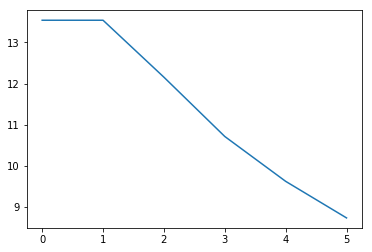

In [81]:
plt.plot(r_values)

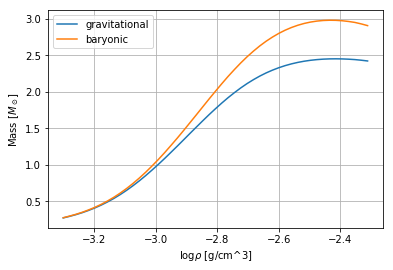

In [43]:
plt.plot(rho, m_values, label = 'gravitational')
plt.plot(rho, M0_values, label = 'baryonic')
plt.legend()
plt.xlabel(r'$\log \rho$ [g/cm^3]')
plt.ylabel(r'Mass [$M_\odot$]')
plt.grid()

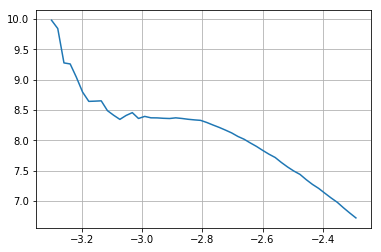

In [43]:
plt.plot(rho, r_values)
plt.grid()

In [ ]:
np.log10(3e15 * 1.6199e-18)

In [ ]:
rho_arr = test.rho_arr
np.min(rho_arr)

In [ ]:
a, b  = test.ye_bounds
print(test.pres_bounds)
print(test.rho_bounds)
test.pres_interp(a, -15), test.pres_interp(b, -13)

In [ ]:
test.ye_bounds

In [ ]:
def f(x):
    return -x
from scipy.integrate import ode 

solver = ode(f)

 
prev_t = 0
prev_y = 1
solver.set_initial_value(prev_y,prev_t)
dx = 0.1
for i in range(20):
    if i == 10:
        solver.set_initial_value(prev_y, 0)
        print(solver.y, prev_y)
        
    plt.scatter(solver.t, solver.y, c ='k')
        
    solver.integrate(solver.t + dx)
    prev_t = solver.t
    prev_y = solver.y

In [ ]:
dir(solver)

In [ ]:

test.P(test.rhoc)
[(test.P(v),v) for v in np.logspace(-10,1,11)]

In [ ]:
test.solve_star()

In [ ]:
T_arr = np.array(f['logtemp'])
ye_arr = np.array(f['ye'])
rho_arr = np.array(f['logrho'])

rho_grid, ye_grid = np.meshgrid(rho_arr, ye_arr)
pres_values = f['logpress'][:,0,:]
munu_values = f['munu'][:,0,:]


ye_pres_points = np.column_stack([ye_grid.ravel(), pres_values.ravel()]),
ye_rho_points  = np.column_stack([ye_grid.ravel(), rho_grid.ravel()]),

rho_interp  = LinearNDInterpolator(ye_pres_points, rho_grid.ravel())
pres_interp = LinearNDInterpolator(ye_rho_points, pres_values.ravel())
munu_interp = LinearNDInterpolator(ye_rho_points, munu_values.ravel())

In [ ]:
func3 = lambda ye, P : munu_interp([ye, P])
ye_bounds = [np.min(ye_arr), np.max(ye_arr)]
res = optimize.root_scalar(func3, method = 'brentq', args=(P), bracket = ye_bounds)
res

In [ ]:
? optimize.fsolve

In [ ]:
rho_interp = interp2d(ye_grid, pres_values, rho_grid)

pres_interp = interp2d(ye_grid, rho_grid, pres_values)

In [ ]:
# rho_interp(0.4, 20)
pres_interp([0.4, 0.7], [4, 5])

In [ ]:
?pres_interp

In [ ]:
a = pres_interp(ye_grid.ravel(), pres_values.ravel())

In [ ]:
np.isclose(a, pres_values)

In [ ]:
rho_interp(0.4, 20)

In [ ]:
%timeit rho_interp(0.4, 20)

In [ ]:
rho_shaped = rho_values.reshape(pres_grid.shape)

In [ ]:
valid_cols = ~np.any(np.isnan(rho_values.reshape(pres_grid.shape)), axis = 0)
rho_valid = rho_shaped[:,valid_cols]

plt.imshow(rho_shaped[:,valid_cols])

In [ ]:
grid_reshaped = grid.reshape(list(pres_grid.shape)+[-1])
plt.pcolormesh(grid_reshaped[:,:,0], grid_reshaped[:,:,1], rho_shaped)

In [ ]:
grid_valid = grid_reshaped[:,valid_cols]
m = plt.pcolormesh(grid_valid[:,:,0], grid_valid[:,:,1], rho_valid)
plt.colorbar(m)

In [ ]:
grid_valid = grid_reshaped[:,valid_cols]

In [ ]:
grid_valid.shape, rho_valid.shape

In [ ]:
sdalsadj

In [ ]:
? interp2d

In [ ]:
rho_interp = interp2d(grid_reshaped[:,valid_cols,0].ravel(), 
                           grid_reshaped[:,valid_cols,1].ravel(), 
                           rho_valid.ravel())

In [ ]:
grid.shape
np.any(np.isnan(rho_values))

In [ ]:
pressure_interp(grid.T[0], grid.T[1])

In [ ]:
Nrho, Ntemp, Nye, pres_values.shape

In [ ]:
m = plt.scatter(ye_grid.ravel(), rho_grid.ravel(), c = pres_values.ravel())
plt.colorbar(m)

In [ ]:
m = plt.scatter(grid.T[0], grid.T[1], marker='.', c = rho_values)
plt.colorbar(m)

In [ ]:
from scipy.interpolate import griddata

pressure_grid = np.linspace(np.min(a), np.max(a), N)
P,_b = np.meshgrid(pressure_grid, b)

print(P.shape)
points = np.array([A.ravel(), c.ravel()]).T
values = B.ravel()
xi = np.array([A.ravel(), c.ravel()]).T

print(B.size, c.size, A.size)
print(points.shape)

gd = griddata(points, values, xi) 
plt.pcolormesh(points[:,0], points[:,1], gd)

In [ ]:
np.concatenate([A.ravel(),B.ravel()])

In [ ]:
np.array(f['logrho'])

 
  - Determine the maximum mass for any five of the EOS available on stellarcollapse.org.
 

 
  - Make mass vs. radius plots for these same five EOS.